In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.ndimage
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [3]:
f = lambda x, y: -np.exp(-(x**2/.7 + y**2/.3)) + 1

In [4]:
xmin, xmax = -1., 1.
ymin, ymax = -1., 1.

In [5]:
x, y = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200))

In [6]:
z = f(x, y)

In [7]:
minimum = np.array([0., 0.])

In [8]:
f(*minimum)

0.0

In [9]:
minimum_ = minimum.reshape(-1, 1)
minimum_

array([[0.],
       [0.]])

In [10]:
f(*minimum_)

array([0.])

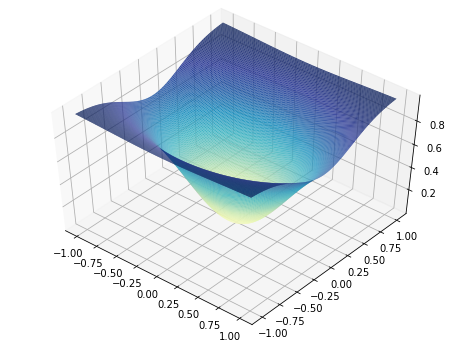

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d", elev=50, azim=-50)

ax.plot_surface(x, y, z, rstride=1, cstride=1, edgecolor="none", cmap=plt.cm.YlGnBu)
plt.show()

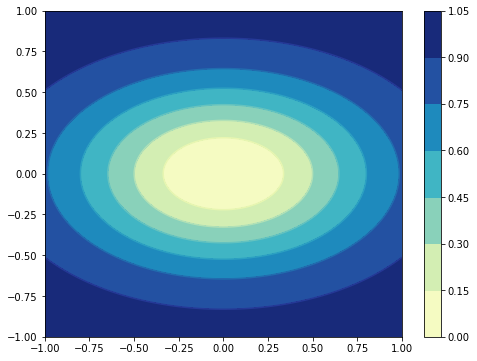

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.contourf(x, y, z, cmap=plt.cm.YlGnBu)
plt.colorbar()
plt.contour(x, y, z, cmap=plt.cm.YlGnBu)

plt.show()

In [13]:
x0 = np.array([0.75, -0.75])

In [14]:
func = value_and_grad(lambda args: f(*args))

In [15]:
def sgd(x0, learning_rate=1e-3, num_steps=100):
    hist = []
    params = x0.copy()
    for i in range(num_steps):
        hist.append(params.copy())
        x, dx = func(params)
        params -= learning_rate * dx
    return np.array(hist)

In [16]:
def sgd_momentum(x0, momentum=0.9, learning_rate=1e-3, num_steps=100):
    hist = []
    params = x0.copy()
    vel = np.zeros(params.shape)
    for i in range(num_steps):
        hist.append(params.copy())
        x, dx = func(params)
        # This implementation of SGD with momentum uses (1 - momentum) for dampening
        vel = momentum * vel + (1 - momentum) * dx
        params -= learning_rate * vel
    return np.array(hist)

In [17]:
def ada_grad(x0, learning_rate=1e-3, num_steps=100):
    hist = []
    params = x0.copy()
    grad_squared = np.zeros(params.shape)
    for i in range(num_steps):
        hist.append(params.copy())
        x, dx = func(params)
        grad_squared += dx * dx
        params -= learning_rate * dx / (np.sqrt(grad_squared) + 1e-8)
    return np.array(hist)

In [18]:
def rms_prop(x0, beta=0.99, learning_rate=1e-3, num_steps=100):
    hist = []
    params = x0.copy()
    grad_squared = np.zeros(params.shape)
    for i in range(num_steps):
        hist.append(params.copy())
        x, dx = func(params)
        grad_squared = beta * grad_squared + (1 - beta) * dx * dx
        params -= learning_rate * dx / (np.sqrt(grad_squared) + 1e-8)
    return np.array(hist)

In [19]:
def adam(x0, beta1=0.9, beta2=0.999, learning_rate=1e-3, num_steps=100):
    hist = []
    params = x0.copy()
    first_moment = np.zeros(params.shape)
    second_moment = np.zeros(params.shape)
    for i in range(num_steps):
        hist.append(params.copy())
        x, dx = func(params)
        first_moment = beta1 * first_moment + (1 - beta1) * dx
        second_moment = beta2 * second_moment + (1 - beta2) * dx * dx
        first_unbias = first_moment / (1 - beta1 ** (i+1))
        second_unbias = second_moment / (1 - beta2 ** (i+1))
        params -= learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-8)
    return np.array(hist)

In [20]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [21]:
paths = [sgd(x0, learning_rate=2e-2).T,
         sgd_momentum(x0, learning_rate=2e-2).T,
         ada_grad(x0, learning_rate=2e-2).T,
         rms_prop(x0, learning_rate=2e-2).T,
         adam(x0, learning_rate=2e-2).T]
methods = ["SGD", "SGD+Momentum", "AdaGrad", "RMSProp", "Adam"]

(-1.0, 1.0, -1.0, 1.0)

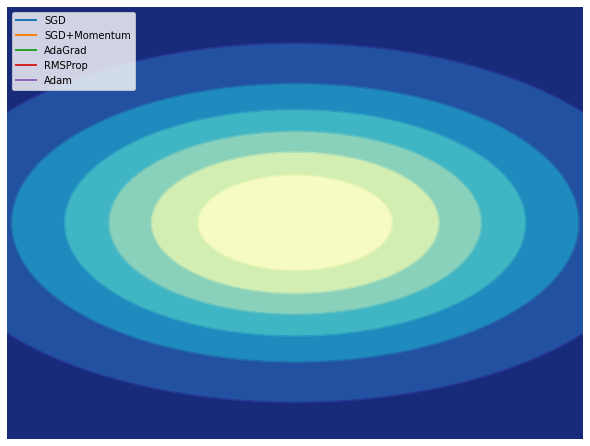

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.contourf(x, y, z, cmap=plt.cm.YlGnBu)
plt.contour(x, y, z, cmap=plt.cm.YlGnBu)

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

plt.legend(loc='upper left')
plt.axis("off")

In [23]:
anim.save("optimizers-animation.gif", writer="imagemagick")